In [190]:
import astropy
from astropy.io import fits
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

In [191]:
#APOKASC file & file variables
hdul = fits.open(r"/Users/amber3/Desktop/SSI/APOKASC_cat_v6.7.2.fits")
hdu = hdul[1]
A_data = hdu.data
#print(np.size(A_data))
KIC_A = hdu.data['KEPLER_INT'] 
Logg_A = hdu.data['DR16_LOGG_COR']
Teff_A = hdu.data['DR16_TEFF_COR']
FeH_A = hdu.data['DR16_M_H_COR']
R_APO3 = hdu.data['APOKASC3P_RADIUS']

In [192]:
#GAIA file variables
#there are some empty entries in error and radius, so flags are put in as -42 and only pos entries are taken
G_data = ascii.read('/Users/amber3/Desktop/gaia_radii_apokasc3 .dat', delimiter = ',') #data_Splitter = 'KIC') #fill_values = [('-42.0', '', '-42.0')])
KIC_G = G_data['KIC']
R_G = 1.0/G_data['inv_r_gaia_K_MIST']
R_G_err_per = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST'] 
R_G_err = R_G_err_per * R_G

In [193]:
#APOLLINAIRE file & file variables (b = background)
hdul_b = fits.open(r"/Users/amber3/Desktop/SSI/Selected_stars_final.fits")
hdu_b = hdul_b[0]
B_data = hdu_b.data
KIC_B = np.array(B_data[:,0,0])

In [194]:
#Intersection between Apollinaire and APOKASC
common_KIC, A_indices, B_indices = np.intersect1d(KIC_A, KIC_B, return_indices=True)

good_indices = np.where((Teff_A[A_indices] > 0) & (R_APO3[A_indices] > 0))
bad_indices = np.where(np.logical_or(Teff_A[A_indices] <= 0, R_APO3[A_indices] <= 0))

B_indices = B_indices[good_indices]
A_indices = A_indices[good_indices]

A_data = A_data[A_indices]
B_data = np.array(B_data[B_indices,:,:])

KIC_B = np.array(B_data[:,0,0])

In [195]:
#intersection between Gaia and (Apollinaire & Apokasc)
common_KIC_G, G_indices, AB_indices = np.intersect1d(KIC_G, KIC_B, return_indices=True)
good_indices = np.where((R_G[G_indices] > 0) & (R_G_err[G_indices] > 0))
G_indices = G_indices[good_indices]
AB_indices = AB_indices[good_indices]

G_data = G_data[G_indices]
A_data = A_data[AB_indices]
B_data = B_data[AB_indices]
KIC_B = KIC_B[AB_indices]

In [196]:
#Raw data Variables
ln10 = np.log(10)
Teff = A_data['DR16_TEFF_COR']
logTeff = np.log10(Teff)
elogTeff = A_data['DR16_TEFF_COR_ERR']/Teff/ln10
logg = A_data['DR16_LOGG_COR']
elogg = A_data['DR16_LOGG_COR_ERR']
FeH = A_data['DR16_M_H_COR']
eFeH = A_data['Dr16_M_H_COR_ERR']
logAmp1 = np.log10(B_data[:,0,6])
elogAmp1 = B_data[:,1,6]/B_data[:,0,6]/ln10
logAmp2 = np.log10(B_data[:,0,9])
elogAmp2 = B_data[:,1,9]/B_data[:,0,9]/ln10
logFreq1 = np.log10(B_data[:,0,7])
elogFreq1 = B_data[:,1,7]/B_data[:,0,7]/ln10
logFreq2 = np.log10(B_data[:,0,10])
elogFreq2 = B_data[:,1,10]/B_data[:,0,10]/ln10
Evolstage = B_data[:,0,3]
itemp = np.where(Evolstage == 1)
iRG = np.reshape(itemp, np.size(itemp))
itemp = np.where(Evolstage == 2)
iRC = np.reshape(itemp, np.size(itemp))
logR_G = -np.log10(G_data['inv_r_gaia_K_MIST'])
elogR_G = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST']/ln10
logR_A = A_data['APOKASC3P_RADIUS'] #check
elogR_A = A_data['APOKASC3P_RADIUS_ERR'] #check
rpw = 2

In [197]:
def linear_fit(X,a,b,c,d):
    x,y,z = X
    return a+b*x+c*y+z*d

In [198]:
#General function for orthogonal fitting of amps and freqs
def odr_fit(A, X):
    x,y,z = X
    return A[0]+A[1]*x+A[2]*y+A[3]*z

In [199]:
def orth_fittings(x,sx,y,sy):
    c_data = odr.RealData(x, y, sx=sx, sy=sy)
    linear = odr.Model(odr_fit)
    beta0 = [183.7, -48.0, -0.73, -0.52] #softcode first linear guesses based j in loop
    c_odr = odr.ODR(c_data, linear, beta0=beta0)
    c_output = c_odr.run()
    #c_output.pprint()
    print(c_output.beta)
    print(c_output.sd_beta)
    return c_output

In [236]:
#coeffs and errors are 4x2x4 arrays (input)
def plottings(coeffs,errors):
    Ncoeff = np.shape(coeffs) #4x2x4
    %matplotlib inline
    figure(figsize=(8,8), dpi=100)
    minimum = np.amin(coeffs-errors)
    maximum = np.amax(coeffs+errors)
    margin = (maximum - minimum)*0.03
    x = [0, 1, 2, 3]

    xl = 0.70
    dxl = 0.15

    labels = ['A1', 'f1', 'A2', 'f2']
    style = ['solid', 'dashed']
    titl = ['red giants', 'red clump']
    color = ['black', 'green', 'purple', 'blue']
    line = [] #'matplotlib.container.ErrorbarContainer']
    for j in range(0,Ncoeff[1]): #(only using r corrected amps), j is rgb=0 or redclump=1
        for k in range(0,Ncoeff[2]): #k is Harvey params of two components. 0=A1, 1=f1, 2=A2, 3=f2
            lin1 = plt.errorbar(x, coeffs[:,j,k], yerr = errors[:,j,k], capsize = 4, linestyle = style[j], label = labels[k], color=color[k])
            line.append(lin1)
            
            #if j == 0 and k == 0:
            #    print('first:',j,k, np.shape(line))
            #else:
            #    print('later:',j,k, np.shape(line))
        leg = plt.legend(handles=line[j*4:(j+1)*4],title = titl[j], loc = (xl+dxl*j,0.8))
        plt.gca().add_artist(leg)
        
    plt.xticks([0, 1, 2, 3], ['const', 'log(Teff)', 'logg', '[Fe/H]'])
    plt.ylabel('Fitting Coefficients')
    plt.show()
    return line
    

In [249]:
NH = 4 #number of Harvery comps
Nj = 8 #j samples of stars: either all red giants, all red clump, subsamples, etc
Np = 3 + 1 #number of atm params plus offset
c = np.ndarray((NH,Nj,Np), dtype=float)
e = np.ndarray((NH,Nj,Np), dtype=float)

for j in (0,1,2,3,4,5,6,7):
    if j < 4:
        if j == 0:
            print('========Using Gaia Radii========')
        logAmp1_R = logAmp1 + rpw * logR_G 
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_G)**2)
        
        logAmp2_R = logAmp2 + rpw * logR_G 
        elogAmp2_R = np.sqrt(elogAmp2**2 + (rpw*elogR_G)**2)
    else:
        if j == 4:
            print('========Using APOKASC3 Radii========')
        logAmp1_R = logAmp1 + rpw * logR_A 
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_A)**2)
        
        logAmp2_R = logAmp2 + rpw * logR_A 
        elogAmp2_R = np.sqrt(elogAmp2**2 + (rpw*elogR_A)**2)
        
    if j == 0 or j == 4: #all red giants
        ii = iRG
        print('RBG Stars')
    elif j == 1 or j == 5: #all red clump
        ii = iRC
        print('Red Clump Stars')
    elif j == 2 or j == 6: #matched subsample giants
        eps = 0.02 #comes from the sorted total differences between atm parameters. Picked as a good threshold to get max paired stars in similar magnitude.
        ii = ()
        iRCs = ()
        dists = ()
        for i in range(0, np.size(iRC)):
            dist2 = (logTeff[iRG]-logTeff[iRC[i]])**2 + ((logg[iRG]-logg[iRC[i]])/3.0)**2 + ((FeH[iRG]-FeH[iRC[i]])/0.8)**2
            dist = np.sqrt(dist2)
            min_dist = (np.min(dist))
            if min_dist < eps:
                index = np.where(dist == min_dist)
                ii = ii + (index[0],)
                iRCs = iRCs + (i,)
                dists = dists + (min_dist,)
        iu = np.unique(ii, return_index=True) #indices of unique elements in red giants
        iu = np.array(iu)[1,:]
        
        Nii = len(ii)
        ii = np.reshape(ii, (Nii,))
        iRCs = np.reshape(iRCs, (Nii,))
        dists = np.reshape(dists, (Nii,))
        
        ii = iRG[ii[iu]]
        iRCs = iRC[iRCs[iu]]
        iRGs = ii
        dists = dists[iu]
        Niu = np.size(iu) #52 
                
        print('Matched RG sample:', np.size(iRCs))
    elif j == 3 or j == 7: #matched subsample clump 
        ii = iRCs
        print('Matched RC sample:', np.size(iRCs))
        #219 matched pairs
    else:
        print('how did we get here??')
    
    x = [logTeff[ii], logg[ii], FeH[ii]]
    sx = [elogTeff[ii], elogg[ii], eFeH[ii]]
    
    y = [logAmp1_R[ii]]
    sy = [elogAmp1_R[ii]]
    print('A1_fit:')
    A1_fit = orth_fittings(x,sx,y,sy)
    c[:,j,0] = A1_fit.beta
    e[:,j,0] = A1_fit.sd_beta
    
    y = [logFreq1[ii]]
    sy = [elogFreq1[ii]]
    print('f1_fit:')
    f1_fit = orth_fittings(x,sx,y,sy)
    c[:,j,1] = f1_fit.beta
    e[:,j,1] = f1_fit.sd_beta
    
    y = [logAmp2_R[ii]]
    sy = [elogAmp2_R[ii]]
    print('A2_fit:')
    A2_fit = orth_fittings(x,sx,y,sy)
    c[:,j,2] = A2_fit.beta
    e[:,j,2] = A2_fit.sd_beta
    
    y = [logFreq2[ii]]
    sy = [elogFreq2[ii]]
    print('f2_fit:')
    f2_fit = orth_fittings(x,sx,y,sy)
    c[:,j,3] = f2_fit.beta
    e[:,j,3] = f2_fit.sd_beta
    

========Using Gaia Radii========
RBG Stars
A1_fit:
[1553.91200077 -433.49686782   16.3937091    -8.53313253]
[390.9061343  110.00066878   4.90387732   2.26913137]
f1_fit:
[ 648.40179735 -182.78328117    9.01718293   -3.81443906]
[234.61005664  66.0284419    2.95470176   1.36637274]
A2_fit:
[1757.42713358 -490.86218322   18.82764702   -9.72299824]
[469.02781353 131.98487147   5.8845417    2.72181383]
f2_fit:
[ 540.59767091 -152.32244583    7.68572835   -3.19539174]
[154.02914558  43.35017443   1.94078938   0.89881977]
Red Clump Stars
A1_fit:
[214.99448654 -57.89197725   1.73909398  -2.1927264 ]
[7.2666475  2.05957383 0.14461038 0.08436862]
f1_fit:
[-92.5283185   26.1938668   -1.15668919   1.09529983]
[4.6920561  1.33168799 0.09147027 0.05402167]
A2_fit:
[245.68215247 -66.71641249   2.2032354   -2.66365744]
[9.13088633 2.58875403 0.18052299 0.10573921]
f2_fit:
[-67.35486573  19.11958133  -0.5998097    0.8154046 ]
[2.43568516 0.69041684 0.04846145 0.02827013]
Matched RG sample: 219
A1_fit

closest KICs in Teff/logg: RGs, RCs, diffs
[11033153.  9536727. 11336656.  2425375. 11043832.] [ 8175438. 12315067.  4852302.  4640537. 11757076.] [0.00140505 0.0016646  0.00223746 0.0023049  0.00386848]

furthest KICS in Teff/logg: RGs, RCs, diffs
[ 9453048. 10208330.  7093179.  8123843.  7457184.] [6288543. 9086505. 4827618. 2853886. 7841977.] [0.14492705 0.1586783  0.17222097 0.2046867  0.2384296 ]


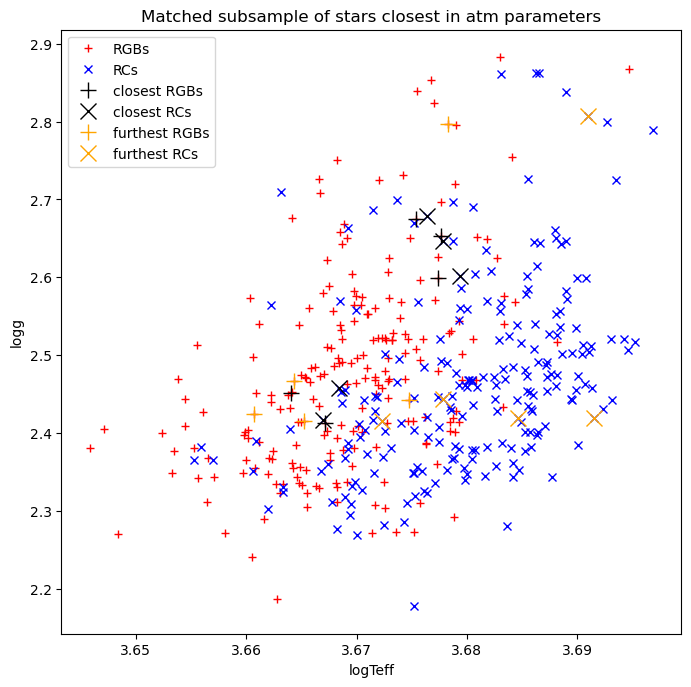

In [250]:
#print(dists[inds])
#print(np.shape(inds), np.size(inds))
inds = np.argsort(dists)

figure(figsize=(8,8), dpi=100)
plt.plot(logTeff[iRGs], logg[iRGs], 'r+', label='RGBs')
plt.plot(logTeff[iRCs], logg[iRCs], 'bx', label='RCs')

list1 = np.array(np.log10(logAmp1[iRGs]))
list2 = np.array(np.log10(logFreq1[iRGs]))

list3 = np.array(np.log10(logAmp1[iRCs]))
list4 = np.array(np.log10(logFreq1[iRCs]))

set_diff = np.sqrt((list1 - list3)**2 + (list2 - list4)**2)
list_diff = np.array(set_diff)

indse = np.argsort(list_diff)

print('closest KICs in Teff/logg: RGs, RCs, diffs')
print(KIC_B[iRGs[inds[0:5]]], KIC_B[iRCs[inds[0:5]]], list_diff[indse[0:5]])
print()
print('furthest KICS in Teff/logg: RGs, RCs, diffs')
print(KIC_B[iRGs[inds[Niu-5:Niu]]], KIC_B[iRCs[inds[Niu-5:Niu]]], list_diff[indse[Niu-5:Niu]])

#matched subsample (219 stars with 2 sets of ten pairs identified)
plt.plot(logTeff[iRGs[inds[0:5]]], logg[iRGs[inds[0:5]]], 'k+', markersize=12, label='closest RGBs')
plt.plot(logTeff[iRCs[inds[0:5]]], logg[iRCs[inds[0:5]]], 'kx', markersize=12, label='closest RCs')
plt.plot(logTeff[iRGs[inds[Niu-5:Niu]]], logg[iRGs[inds[Niu-5:Niu]]], color='orange', marker='+', linestyle='none', markersize=12, label='furthest RGBs')
plt.plot(logTeff[iRCs[inds[Niu-5:Niu]]], logg[iRCs[inds[Niu-5:Niu]]], color='orange', marker='x', linestyle='none', markersize=12, label='furthest RCs')
plt.xlabel('logTeff')
plt.ylabel('logg')
plt.title('Matched subsample of stars closest in atm parameters')
plt.legend(loc='upper left')

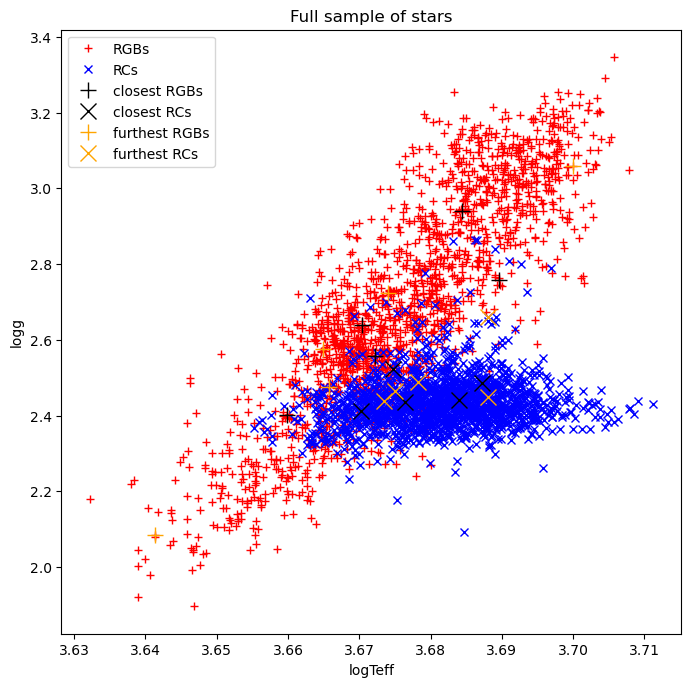

In [251]:
#full sample diagram with same 10 pairs pointed out
figure(figsize=(8,8), dpi=100)
plt.plot(logTeff[iRG], logg[iRG], 'r+', label='RGBs')
plt.plot(logTeff[iRC], logg[iRC], 'bx', label='RCs')

plt.plot(logTeff[iRG[inds[0:5]]], logg[iRG[inds[0:5]]], 'k+', markersize=12, label='closest RGBs')
plt.plot(logTeff[iRC[inds[0:5]]], logg[iRC[inds[0:5]]], 'kx', markersize=12, label='closest RCs')
plt.plot(logTeff[iRG[inds[Niu-5:Niu]]], logg[iRG[inds[Niu-5:Niu]]], color='orange', marker='+', linestyle='none', markersize=12, label='furthest RGBs')
plt.plot(logTeff[iRC[inds[Niu-5:Niu]]], logg[iRC[inds[Niu-5:Niu]]], color='orange', marker='x', linestyle='none', markersize=12, label='furthest RCs')
plt.xlabel('logTeff')
plt.ylabel('logg')
plt.title('Full sample of stars')
plt.legend(loc='upper left')

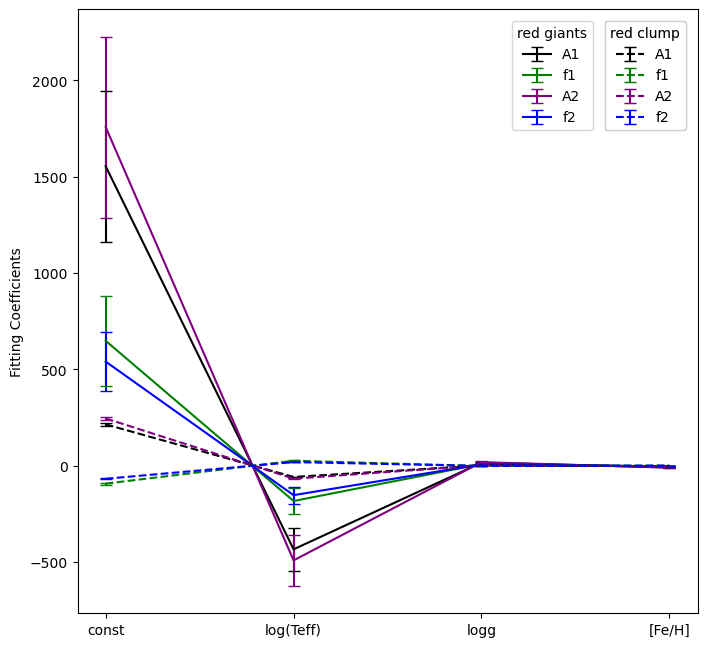

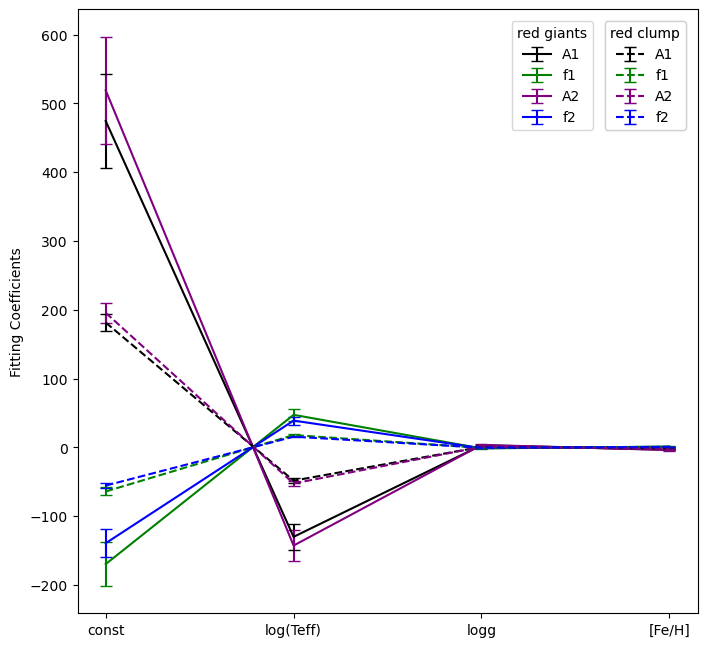

In [252]:
#call plottings with 4 subplots here 
#reshape arrays here
#two plots with whole sample, Gaia and APO3
#two plots with subsample, Gaia and APO3
#choose which radius we're using for each plot here?
#add titles here also
#add overplotting variable so we can change between two different radii, or full and matched subsamples, etc

#print(np.shape(c),np.shape(e))
#print(c)
#plt.plot(c[0,0,:])
#plt.show()
#full sample plot
line = plottings(c[:,0:2,:],e[:,0:2,:]) #4x2x4 array input
#matched subsample plot
line = plottings(c[:,2:4,:],e[:,2:4,:])
#print(np.shape(c[:,0:2,:]), np.shape(c[:,2:4,:]))
#GAIA GRAPHS BELOW

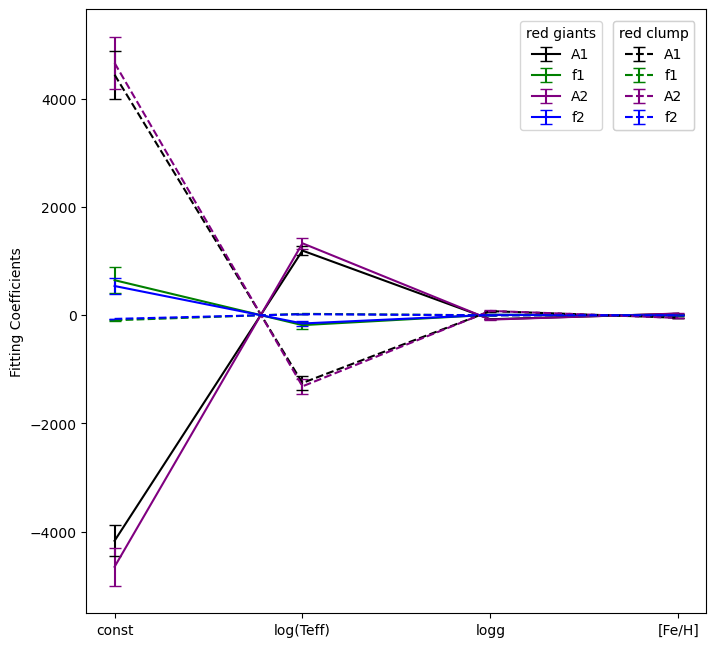

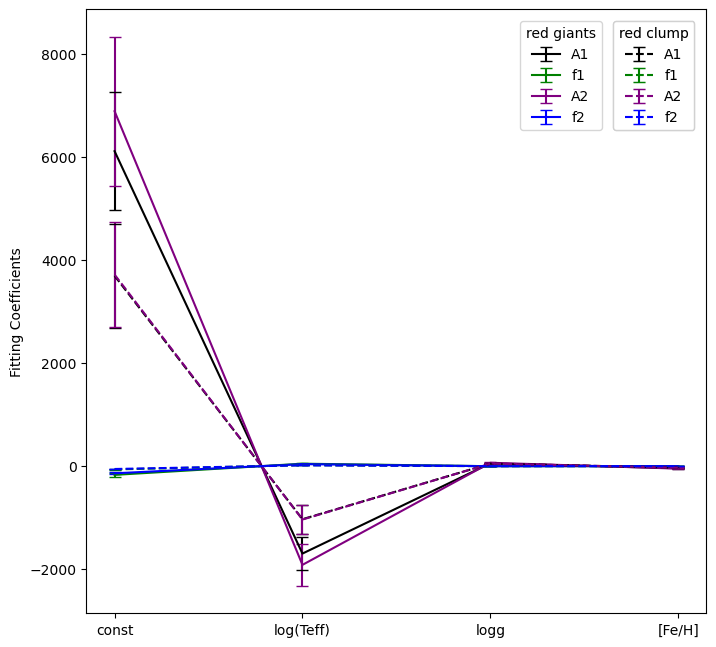

In [253]:
line = plottings(c[:,4:6,:],e[:,4:6,:]) #4x2x4 array input
#matched subsample plot
line = plottings(c[:,6:8,:],e[:,6:8,:])
#APOKASC3 GRAPHS BELOW